In [220]:
%matplotlib inline
import numpy as np
import scipy as sp
from itertools import product
import json 
import csv
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Cleaning up the Data a bit more

Now that we have successfully wrangled our data in a way that allowed us to develop indicators and standardizable quantities, we have to do a few more things to make it operable with the sklearn packages like used in HW3. We removed a transfer index 'Unnamed' and pull out two more columns. ListingStatus is the same for all (we only took completed listings) and only 2 entries of our dataset had ReserveMet as True. The NaNs otherwise would cause problems with standardization.

In [227]:
df=pd.read_csv("dftouse_textanalysis.csv")

In [228]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']
del df['ReserveMet']
del df['ListingStatus']
df = df[pd.isnull(df.HitCount) == False]


In [229]:
dftouse = df.copy()
dftouse.head()

,country,itemId,paymentMethod,postalCode,sellingStatus,topRatedListing,AutoPay,AvailableForPickupDropOff,BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,GlobalShipping,HandlingTime,HitCount,ListingType,Location,MinimumToBid,ProductID,Quantity,QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,SellerBusinessType,NewUser,nPhotos,nPaymentMethods,nShippingCountries,conditionId,bestOfferEnabled,buyItNowAvailable,expeditedShipping,shippingType,oneDayShippingAvailable,RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,enoughKeyWords
0,0,131642735687,0,10590,0,False,False,0,False,41,NaN,202.09,False,2,190,0,"South Salem, New York",204.59,NaN,1,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,19,100.0,2,False,3,1,1,5,False,False,True,2,False,False,NaN,0,0,5,5,168,False
1,0,262126933108,0,35004,0,False,False,0,False,4,NaN,260.00,False,3,32,0,"Moody, Alabama",265.00,NaN,1,0,US,apple iphone 5s 32gb,forwhlrcr1965,565,100.0,1,False,2,1,1,5,False,False,True,0,False,False,NaN,0,0,3,32,120,False
2,0,252155964081,0,98104,0,False,False,0,False,3,NaN,152.50,False,2,168,0,"Seattle, Washington",155.00,168534287,1,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120,True
3,0,252163774777,0,98104,0,False,False,0,False,1,NaN,99.00,False,2,143,0,"Seattle, Washington",100.00,168553370,1,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,15,94.1,1,False,7,1,1,9,False,False,True,0,False,False,NaN,0,1,2,17,120,True
4,0,252171170160,0,98104,0,False,True,0,False,5,NaN,96.00,False,2,357,0,"Seattle, Washington",97.00,168534287,1,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,15,94.1,1,False,2,1,1,5,False,False,False,1,False,False,NaN,0,1,2,17,120,True


## A quick look

Let's take a first glance at the comparison of some of our important variables. Two important important variables that tell us about a successful auction are the FinalPrice and what the sellingStatus of the item is, which is 0 for a sold item and 1 for an item that did not sell. We also look at:

        - RatingsPresent: whether or not they made their ratings visible
        - PositiveFeedbackPercent: if this is 100, people never complain about this seller
        - conditionId: if the item new or used, and to what extent is it used. New is 0, 8-9 is not fully functional

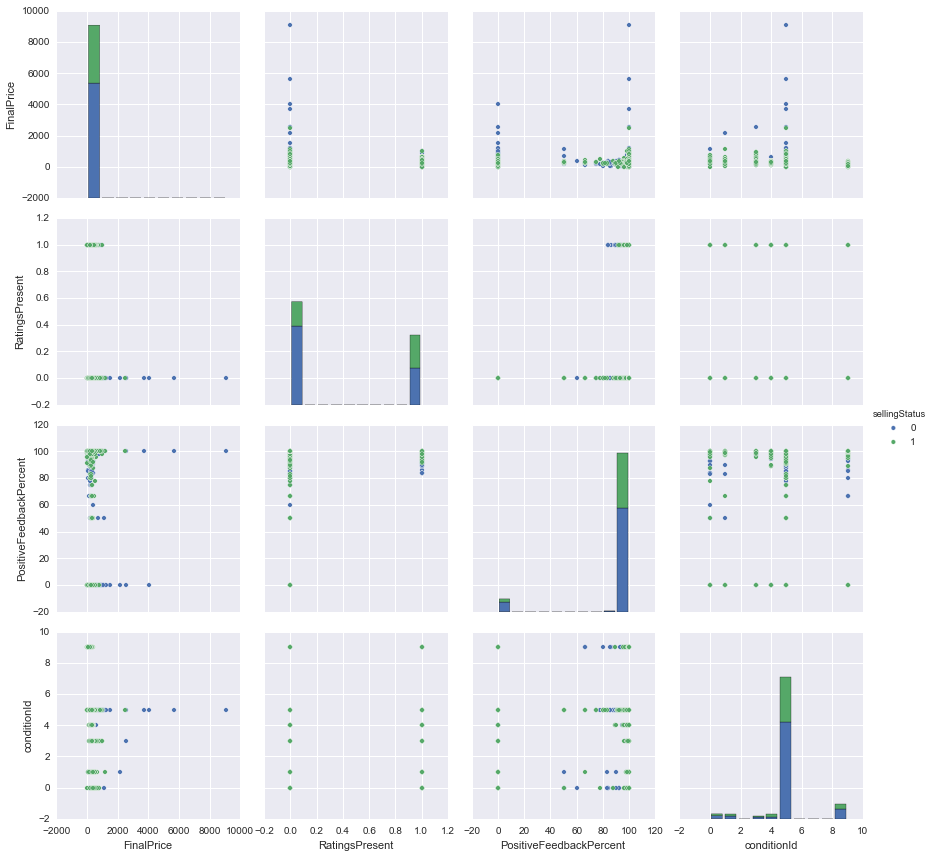

In [230]:
import seaborn as sns
sns.set()

sns.pairplot(df, hue='sellingStatus', vars=['FinalPrice','RatingsPresent','PositiveFeedbackPercent','conditionId'], size=3)

We see that very few people have a positive feedback percent in the range between 0 and 100, and that most of the ratings are either near 0% or near 100%. This tells us that very few ebay sellers are polarizing - either they are consistently bad or good, or some of those near 0% and 100% haven't sold many items so their small sample size naturally condones something near 0% or 100%. The most common condition of an item is conditionId 5, which, according to our dataframe_manipulation ipython notebook, indicates a conditionId of "Used". Everyone with a 0% positive feedback rating, irregardless of item condition, did not successfully sell their item. The vast majority of people also have positive feedback, which is good for worldly morality! Interestingly, while overall our dataframe is split ~65% sold 35% didn't sell, when people made their ratings present, a larger portion of them failed to sell. 

## Now we will do some Feature engineering

This is to figure out which variables actually make a distinction on item sellability. We separate our variables in similar manner to Homework 3.

In [231]:
ZERO_IMPORTANT_VARIABLES = ['BidCount', 'HitCount', 'nPhotos', 'FeedbackScore', 'PositiveFeedbackPercent',
                           'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day']
STANDARDIZABLE = ZERO_IMPORTANT_VARIABLES + ['FinalPrice','auctionLength', 'HandlingTime', 'FeedbackScore', 
                  'PositiveFeedbackPercent', 'Quantity', 'nPaymentMethods', 'nShippingCountries', 'auctionLength']
INDICATORS = []

**We go ahead and make our list of indicators, making sure to not duplicate indicator names based on the list they are in.**

In [232]:
for v in df.columns:
    if v != 'sellingStatus':
        l=df[v].unique()
        if len(l) <= 10:
            if v not in STANDARDIZABLE:
                dftouse.rename(columns={v:'i_'+v}, inplace=True)
                INDICATORS.append('i_'+v)
            else:
                dftouse['i_'+v]=(dftouse[v] > 0.0)*1
                INDICATORS.append('i_'+v)
            print v, l

for v in ZERO_IMPORTANT_VARIABLES:
    dftouse['i_'+v]=(dftouse[v] > 0.0)*1
    INDICATORS.append('i_'+v)
    print v
    
#INDICATORS.remove('i_sellingStatus')
print INDICATORS


country [0 1]
paymentMethod [0 1]
topRatedListing [False True]
AutoPay [False True]
AvailableForPickupDropOff [0 1]
BestOfferEnabled [False True]
GlobalShipping [False True]
HandlingTime [ 2.  3.  1.  0.]
ListingType [0 1]
QuantityThreshold [  0.  10.]
SellerBusinessType [2 1 0]
NewUser [False True]
nPaymentMethods [1 2 4 3]
conditionId [5 9 0 1 3 4]
bestOfferEnabled [False True]
buyItNowAvailable [False True]
expeditedShipping [True False]
shippingType [ 2.  0.  1.  3.  4.  8.]
oneDayShippingAvailable [False True]
RatingsPresent [False True]
enoughKeyWords [False True]
BidCount
HitCount
nPhotos
FeedbackScore
PositiveFeedbackPercent
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
['i_country', 'i_paymentMethod', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'i_GlobalShipping', 'i_HandlingTime', 'i_ListingType', 'i_QuantityThreshold', 'i_SellerBusinessType', 'i_NewUser', 'i_nPaymentMethods', 'i_conditionId', 'i_bestOfferEnab

We divide our dataframe up into a training and a test set in order to run our regressions and SVMs on the data. Our goal here is to figure out what probability of selling maximizes our profit, so we look to get the best estimate of sellingStatus so that we can use it later on.

In [233]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)

In [234]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [235]:
mask.shape, mask.sum()

((9267,), 6486)

Here we standardize our two masks (train and test) separately to make them distinct so that we have an essentially independent dataset to test our predictor on. Doing so allows us to better understand if we are doing a good job with predicting *any* set of iPhone 5s 32gb auction data and not just predicting the data we already had really well.

In [236]:
from sklearn import preprocessing

#we make our training and testing sets w/ standarized
scaler = preprocessing.StandardScaler().fit(dftouse[mask][STANDARDIZABLE])
dftouse.loc[mask, STANDARDIZABLE] = scaler.transform(dftouse[mask][STANDARDIZABLE]) 
dftouse.loc[~mask,STANDARDIZABLE] = scaler.transform(dftouse[~mask][STANDARDIZABLE])


dftouse[mask].head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,0,131642735687,0,10590,0,False,False,0,False,2.711075,NaN,-0.411158,False,0.425438,-0.037134,0,"South Salem, New York",204.59,NaN,-0.046912,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.219917,0.298328,2,False,-0.817452,-0.077308,-0.815884,5,False,False,True,2,False,False,NaN,-0.151625,-0.229590,-0.263598,-0.303366,0.047715,False,1,1,1,1,1,1,1,0,0,1,1
1,0,262126933108,0,35004,0,False,False,0,False,-0.228416,NaN,0.037578,False,1.782069,-0.054060,0,"Moody, Alabama",265.00,NaN,-0.046912,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.201210,0.298328,1,False,-1.145242,-0.077308,-0.815884,5,False,False,True,0,False,False,NaN,-0.151625,-0.229590,-0.271815,-0.294405,-0.056877,False,1,1,1,1,1,1,1,0,0,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.466753,NaN,-1.209986,False,0.425438,-0.042169,0,"Seattle, Washington",100.00,168553370,-0.046912,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.220054,0.067978,1,False,0.493706,-0.077308,-0.815884,9,False,False,True,0,False,False,NaN,-0.151625,-0.195231,-0.275924,-0.299384,-0.056877,True,1,1,1,1,1,1,1,0,1,1,1
5,0,252171162991,0,98104,0,False,False,0,False,-0.307861,NaN,-1.341717,False,0.425438,-0.024814,0,"Seattle, Washington",83.00,168553370,-0.046912,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.220054,0.067978,1,False,0.493706,-0.077308,-0.815884,9,False,False,True,0,False,False,NaN,-0.151625,-0.195231,-0.275924,-0.299384,-0.056877,True,1,1,1,1,1,1,1,0,1,1,1
7,0,171993101164,0,27045,0,False,True,0,False,-0.546198,NaN,-0.001166,True,0.425438,-0.055559,1,"Rural Hall, North Carolina",NaN,168553370,-0.046912,0,"[US, CA, GB, DK, RO, SK, BG, CZ, FI, HU, LV, L...",Apple iPhone 5s 32GB CUSTOM BlacK/Silver Veriz...,clint22468,-0.193090,0.278807,1,False,2.132653,-0.077308,1.300000,5,False,False,False,3,False,True,4.9275,-0.151625,-0.195231,-0.115689,-0.235329,-0.318357,True,1,1,0,1,1,1,1,0,1,1,1


In [237]:
lcols=list(dftouse.columns)
print lcols
lcols.remove(u'sellingStatus')
print len(lcols)

['i_country', 'itemId', 'i_paymentMethod', 'postalCode', 'sellingStatus', 'i_topRatedListing', 'i_AutoPay', 'i_AvailableForPickupDropOff', 'i_BestOfferEnabled', 'BidCount', 'BuyItNowPrice', 'FinalPrice', 'i_GlobalShipping', 'HandlingTime', 'HitCount', 'i_ListingType', 'Location', 'MinimumToBid', 'ProductID', 'Quantity', 'i_QuantityThreshold', 'ShipToLocations', 'Title', 'UserID', 'FeedbackScore', 'PositiveFeedbackPercent', 'i_SellerBusinessType', 'i_NewUser', 'nPhotos', 'nPaymentMethods', 'nShippingCountries', 'i_conditionId', 'i_bestOfferEnabled', 'i_buyItNowAvailable', 'i_expeditedShipping', 'i_shippingType', 'i_oneDayShippingAvailable', 'i_RatingsPresent', 'AverageRating', 'NegFeedback30Day', 'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day', 'auctionLength', 'i_enoughKeyWords', 'i_HandlingTime', 'i_nPaymentMethods', 'i_BidCount', 'i_HitCount', 'i_nPhotos', 'i_FeedbackScore', 'i_PositiveFeedbackPercent', 'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day', '

In [238]:
ccols=[]
for c in lcols:
    if c not in INDICATORS:
        ccols.append(c)


ccols.remove('itemId')
ccols.remove('postalCode')
#ccols.remove('sellingStatus')
ccols.remove('Location')
ccols.remove('ProductID')
ccols.remove('ShipToLocations')
ccols.remove('Title')
ccols.remove('UserID')
print len(ccols), len(INDICATORS)

18 30


In [239]:
dftouse.head()

,i_country,itemId,i_paymentMethod,postalCode,sellingStatus,i_topRatedListing,i_AutoPay,i_AvailableForPickupDropOff,i_BestOfferEnabled,BidCount,BuyItNowPrice,FinalPrice,i_GlobalShipping,HandlingTime,HitCount,i_ListingType,Location,MinimumToBid,ProductID,Quantity,i_QuantityThreshold,ShipToLocations,Title,UserID,FeedbackScore,PositiveFeedbackPercent,i_SellerBusinessType,i_NewUser,nPhotos,nPaymentMethods,nShippingCountries,i_conditionId,i_bestOfferEnabled,i_buyItNowAvailable,i_expeditedShipping,i_shippingType,i_oneDayShippingAvailable,i_RatingsPresent,AverageRating,NegFeedback30Day,NegFeedback365Day,PosFeedback30Day,PosFeedback365Day,auctionLength,i_enoughKeyWords,i_HandlingTime,i_nPaymentMethods,i_BidCount,i_HitCount,i_nPhotos,i_FeedbackScore,i_PositiveFeedbackPercent,i_NegFeedback30Day,i_NegFeedback365Day,i_PosFeedback30Day,i_PosFeedback365Day
0,0,131642735687,0,10590,0,False,False,0,False,2.711075,NaN,-0.411158,False,0.425438,-0.037134,0,"South Salem, New York",204.59,NaN,-0.046912,0,US,iPhone 5s-32gb-Space Gray-unlocked,jdwein1980,-0.219917,0.298328,2,False,-0.817452,-0.077308,-0.815884,5,False,False,True,2,False,False,NaN,-0.151625,-0.229590,-0.263598,-0.303366,0.047715,False,1,1,1,1,1,1,1,0,0,1,1
1,0,262126933108,0,35004,0,False,False,0,False,-0.228416,NaN,0.037578,False,1.782069,-0.054060,0,"Moody, Alabama",265.00,NaN,-0.046912,0,US,apple iphone 5s 32gb,forwhlrcr1965,-0.201210,0.298328,1,False,-1.145242,-0.077308,-0.815884,5,False,False,True,0,False,False,NaN,-0.151625,-0.229590,-0.271815,-0.294405,-0.056877,False,1,1,1,1,1,1,1,0,0,1,1
2,0,252155964081,0,98104,0,False,False,0,False,-0.307861,NaN,-0.795423,False,0.425438,-0.039491,0,"Seattle, Washington",155.00,168534287,-0.046912,0,Worldwide,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.220054,0.067978,1,False,-1.145242,-0.077308,-0.815884,5,False,False,False,1,False,False,NaN,-0.151625,-0.195231,-0.275924,-0.299384,-0.056877,True,1,1,1,1,1,1,1,0,1,1,1
3,0,252163774777,0,98104,0,False,False,0,False,-0.466753,NaN,-1.209986,False,0.425438,-0.042169,0,"Seattle, Washington",100.00,168553370,-0.046912,0,US,Apple iPhone 5s - 32GB - Silver (Verizon) Smar...,15-alice,-0.220054,0.067978,1,False,0.493706,-0.077308,-0.815884,9,False,False,True,0,False,False,NaN,-0.151625,-0.195231,-0.275924,-0.299384,-0.056877,True,1,1,1,1,1,1,1,0,1,1,1
4,0,252171170160,0,98104,0,False,True,0,False,-0.148970,NaN,-1.233233,False,0.425438,-0.019244,0,"Seattle, Washington",97.00,168534287,-0.046912,0,US,Apple iPhone 5s - 32GB SPACE GRAY AT&T,15-alice,-0.220054,0.067978,1,False,-1.145242,-0.077308,-0.815884,5,False,False,False,1,False,False,NaN,-0.151625,-0.195231,-0.275924,-0.299384,-0.056877,True,1,1,1,1,1,1,1,0,1,1,1


Creating a set of **K**ernel **De**nsity Plots (KDE) allows us to look at the non-indicator data that has a wide range of values to see how they vary depending on sellability or not.

BidCount
BuyItNowPrice
FinalPrice
HandlingTime
HitCount
MinimumToBid
Quantity
FeedbackScore
PositiveFeedbackPercent
nPhotos
nPaymentMethods
nShippingCountries
AverageRating
NegFeedback30Day
NegFeedback365Day
PosFeedback30Day
PosFeedback365Day
auctionLength


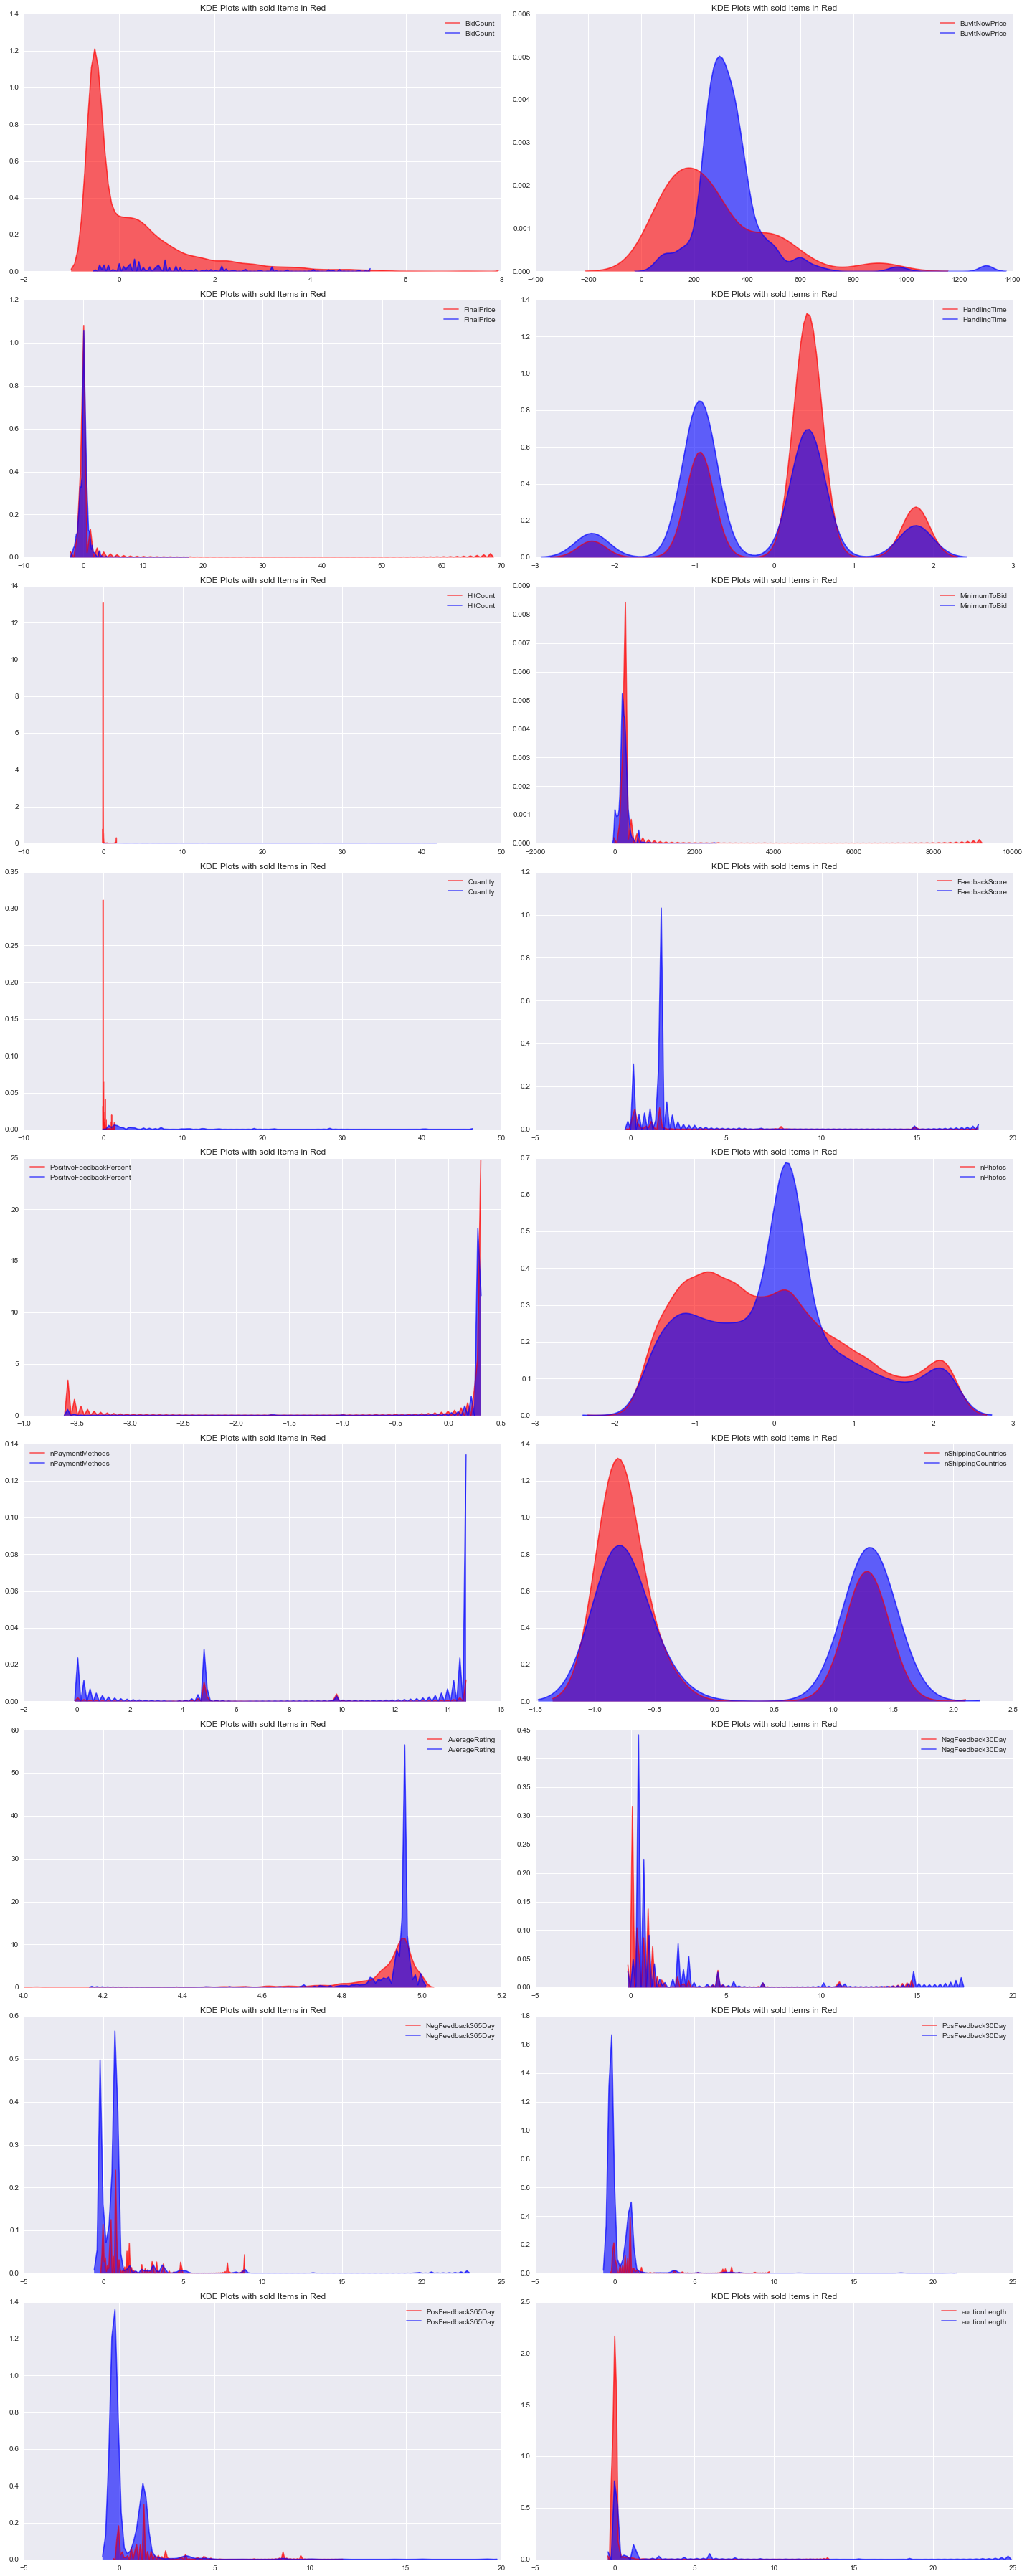

In [240]:
fig, axes = plt.subplots(nrows=9, ncols=2, sharex=False, sharey=False, figsize=(20, 50), 
                         tight_layout=True)
for ax, ccol in zip(axes.ravel(), ccols):
    
    #plot mean values per year based on response to mailing
    df_col = dftouse[ccol]
    print ccol
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 0], color='r', alpha=.6, ax=ax, shade=True, legend=True)
    sns.kdeplot(df_col[dftouse['sellingStatus'] == 1], color='b', alpha=.6, ax=ax, shade=True)
    ax.set_title("KDE Plots with sold Items in Red")

Next we do a similar binary plot of sold vs. not sold for our indicators. How each of these are defined is explained in the dataframe_manipulation notebook in the mapping section.

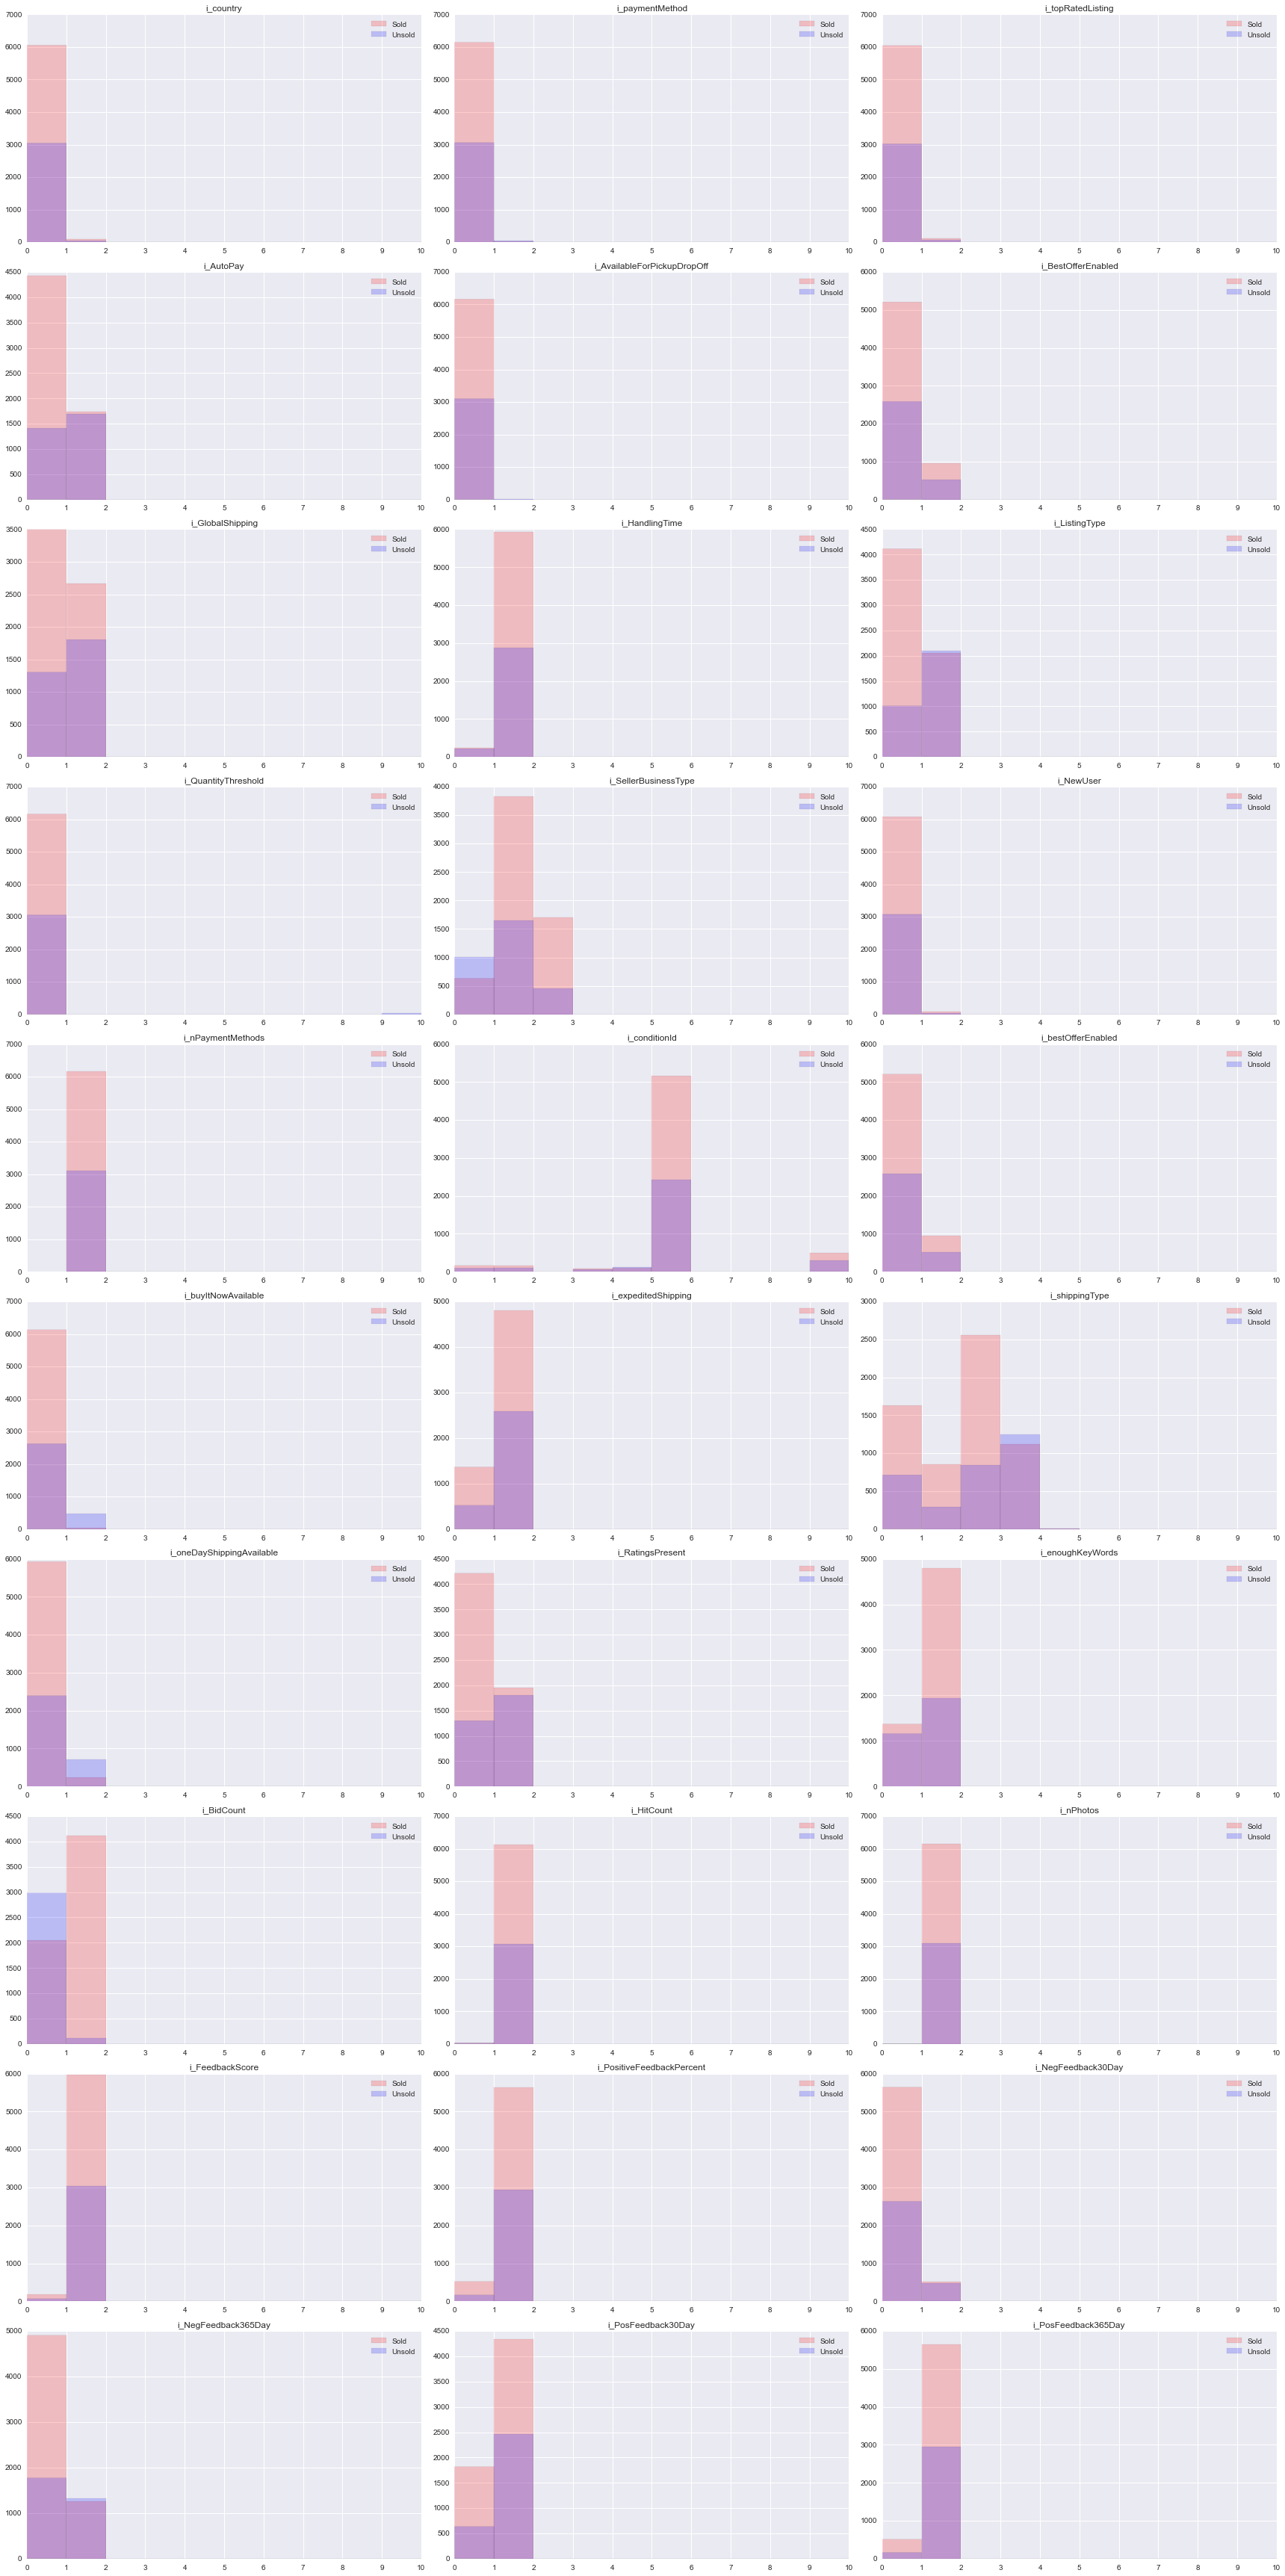

In [241]:
#setup similar layout
fig, axes = plt.subplots(nrows=10, ncols=3, figsize = (24,48),
                         tight_layout=True)

positives = dftouse[dftouse['sellingStatus'] == 0]
negatives = dftouse[dftouse['sellingStatus'] == 1]

for ax, data in zip(axes.ravel(), INDICATORS):
    ax.hist(positives[data].values, bins=10, range=[0,10], color = 'r', alpha = 0.2, label = 'Sold', rwidth=10)
    ax.hist(negatives[data].values, bins=10, range=[0,10], color = 'b', alpha = 0.2, label = 'Unsold', bottom=1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
    ax.legend()
    ax.set_title(data)

We notice some obvious indications, like that with autoPay, where, while having autopay is most common (the majority of histogram values are in the 0 bin), the distribution of sold or not sold moves much more heavily toward not sold when autoPay isn't an option (bin 1). 

In [132]:
from sklearn.svm import LinearSVC

We remove the columns below from our current analysis because they contain NaN values or are not all workable indicating quantities. It would be interesting to do an analysis of how location affects sellability, but that isn't the crux of our analysis right now.

In [133]:

lcols.remove('UserID')
lcols.remove('itemId')
lcols.remove('Title')
lcols.remove('ShipToLocations')
lcols.remove('Location')
lcols.remove('postalCode')
lcols.remove('ProductID')
lcols.remove('AverageRating')
lcols.remove('BuyItNowPrice')
lcols.remove('MinimumToBid')


In [134]:
clfsvm=LinearSVC(loss="hinge")
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
Xmatrix=dftouse[lcols].values
Yresp=dftouse['sellingStatus'].values

In [135]:
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [136]:
#Xmatrix_train
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

BEST {'C': 10.0} 0.807277212458 [mean: 0.71523, std: 0.04099, params: {'C': 0.001}, mean: 0.79679, std: 0.04115, params: {'C': 0.01}, mean: 0.79510, std: 0.04534, params: {'C': 0.1}, mean: 0.80435, std: 0.04204, params: {'C': 1.0}, mean: 0.80728, std: 0.04118, params: {'C': 10.0}, mean: 0.80466, std: 0.04992, params: {'C': 100.0}]


In [137]:
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
best = gs.best_estimator_
best.fit(Xmatrix_train, Yresp_train)
best.score(Xmatrix_test, Yresp_test)

BEST {'C': 10.0} 0.807277212458 [mean: 0.71523, std: 0.04099, params: {'C': 0.001}, mean: 0.79679, std: 0.04115, params: {'C': 0.01}, mean: 0.79510, std: 0.04534, params: {'C': 0.1}, mean: 0.80435, std: 0.04204, params: {'C': 1.0}, mean: 0.80728, std: 0.04118, params: {'C': 10.0}, mean: 0.80466, std: 0.04992, params: {'C': 100.0}]


0.85113268608414239

In [138]:
best

LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [139]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5,score_func=None):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds,scoring=score_func)
    gs.fit(X, y)
    best = gs.best_estimator_
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    return best

In [140]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [141]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, mask=mask)

using mask
BEST {'C': 10.0} 0.807585568918 [mean: 0.71523, std: 0.04099, params: {'C': 0.001}, mean: 0.79679, std: 0.04115, params: {'C': 0.01}, mean: 0.79541, std: 0.04564, params: {'C': 0.1}, mean: 0.80327, std: 0.04361, params: {'C': 1.0}, mean: 0.80759, std: 0.04377, params: {'C': 10.0}, mean: 0.74669, std: 0.08434, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.85
Accuracy on test data:     0.85
[[1734  138]
 [ 284  625]]
########################################################
CPU times: user 13 s, sys: 85.4 ms, total: 13.1 s
Wall time: 13.9 s


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [142]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

In [143]:

##this tells us that most of our values are closer to 0 than 1, which means most were successful sales
print "whole data set", dftouse['sellingStatus'].mean()#Highly asymmetric
print "training set", dftouse['sellingStatus'][mask].mean(), "test set", dftouse['sellingStatus'][~mask].mean()

whole data set 0.334844070357
training set 0.338267036694 test set 0.326860841424


In [144]:
ypred=clfsvm.predict(Xtest)
confusion_matrix(ytest, ypred)

array([[1734,  138],
       [ 284,  625]])

In [145]:
print "OP=", ytest.sum(), ", ON=",ytest.shape[0] - ytest.sum()

OP= 909 , ON= 1872


In [146]:
print "PP=", ypred.sum(), ", ON=",ytest.shape[0] - ypred.sum()

PP= 763 , ON= 2018


In [147]:
# taking approx. average cost of listing based on whether using images, bold, short burst shor auctions, etc
listing_fee = 4.2

## we calcluate how many of our listings are top rated listings assuming our data is an simple random sample to get
## a probability of a listing being a top rated listing
size_df = float(len(dftouse.index))
y = float(len(dftouse[dftouse['i_topRatedListing'] == True]))
prob_toprated = y/size_df

## we get 90% of the profit from the sale, and if you are a top rated listing, you get %20 percent off this 10% charge
profit_margin=.9 +(.02 * prob_toprated)

## We calculate the true positive cost using the listing fee and subtracting off the profit made. We have to 
## average over new or used to make the mean better weighted for the "value" of the iPhone. We take the used value to 
## be 70% of the new value based on the fact that Apple currently sells the new one for $500 and refurbished for $340
## BestBuy: http://www.bestbuy.com/site/apple-refurbished-iphone-5s-32gb-cell-phone-unlocked-silver/1311862035.p?id=mp1311862035&skuId=1311862035
## Apple New: http://www.apple.com/shop/buy-iphone/iphone5s/32gb-space-gray

new = float(len(dftouse[dftouse['i_conditionId'] == 0]))
prob_new = new/size_df
prob_used = 1 - prob_new
profit = ((df.FinalPrice.mean())*prob_new + (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin

# diff = 250 - ((df.FinalPrice.mean())*prob_new + 200 - (df.FinalPrice.mean())*(.7 * prob_used))*profit_margin


# As of December 10, 2015, Apple offers up to $320 dollars for iphone take-ins:
# http://www.apple.com/iphone/trade-in/?cid=&cp=em-P0016950-349230&sr=em
# However, other places, such as verizon and AT&T, take iphones in anwhere from 135-300 on average
# We scale the average of these for new and used eBay items, and make this part of our opportunity cost
diff = prob_new * (280 - df.FinalPrice.mean()*profit_margin) + prob_used*(225-(.7*df.FinalPrice.mean()*profit_margin))

#tpc
tpc = diff + listing_fee - profit

#tnc
tnc= -diff

# ## because we have no listing fee, our fnc is just (-tpc)
fnc = diff

# ## and our false positive cost is thus, what we would spend for listing when we shouldn't have
fpc = listing_fee + diff


In [148]:
risk_matrix=np.array([[tnc, fpc],[fnc, tpc]])
risk_matrix

array([[-63.26468395,  67.46468395],
       [ 63.26468395, -95.80780701]])

In [149]:
u = - risk_matrix

## to avoice writing -0
#u[0][0] = 0.
#u[0][1] = 0.
u

array([[ 63.26468395, -67.46468395],
       [-63.26468395,  95.80780701]])

In [150]:
def average_profit_pp(y, ypred, u):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*u)/np.sum(c)
    return score

In [151]:
#baseline classifier #1: don't sell anything
testsize = dftouse[~mask].shape[0]
ypred_dste = np.zeros(testsize, dtype="int")
print confusion_matrix(ytest, ypred_dste)
dsteval=average_profit_pp(ytest, ypred_dste, u)
dsteval

[[1872    0]
 [ 909    0]]


21.907188294677127

In [152]:
#baseline classifier #2: sell everything
testsize = dftouse[~mask].shape[0]
ypred_ste = np.ones(testsize, dtype="int")
print confusion_matrix(ytest, ypred_ste)
steval=average_profit_pp(ytest, ypred_ste, u)
steval

[[   0 1872]
 [   0  909]]


-14.097300174609876

In [153]:
#calculating profit from SVM classifer using baselines
testsize = dftouse[~mask].shape[0]
ypred_svm=clfsvm.predict(Xtest)
print confusion_matrix(ytest, ypred_svm)
svmval=average_profit_pp(ytest, ypred_svm, u)
svmval

[[1734  138]
 [ 284  625]]


51.169918997208995

In [154]:
#logistic regression with Lasso based feature selection
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l1")
cvals = {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
clflog, Xtrain, ytrain, Xtest, ytest = do_classify(clf, cvals, dftouse,lcols, 'sellingStatus',1, mask=mask, reuse_split=reuse_split)

using mask
using reuse split
BEST {'C': 10.0} 0.811748381129 [mean: 0.66173, std: 0.00019, params: {'C': 0.001}, mean: 0.78677, std: 0.04963, params: {'C': 0.01}, mean: 0.80974, std: 0.03569, params: {'C': 0.1}, mean: 0.81144, std: 0.03954, params: {'C': 1.0}, mean: 0.81175, std: 0.04005, params: {'C': 10.0}, mean: 0.81175, std: 0.04103, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.86
[[1704  168]
 [ 215  694]]
########################################################


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [155]:
#calculating profit
testsize = dftouse[~mask].shape[0]
ypred_lreg=clflog.predict(Xtest)
print confusion_matrix(ytest, ypred_lreg)
lregval=average_profit_pp(ytest, ypred_lreg, u)
lregval

[[1704  168]
 [ 215  694]]


53.706460111758879

In [156]:
#Part 3
#function to make roc curves
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

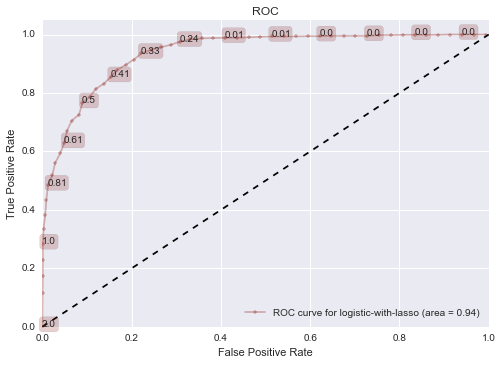

In [157]:
#logistic lasso ROC curve
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)

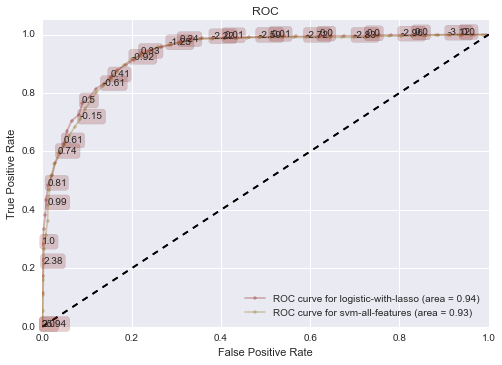

In [158]:
#logistic lasso vs. all features SVM
with sns.hls_palette(8, l=.3, s=.8):
    ax=make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)

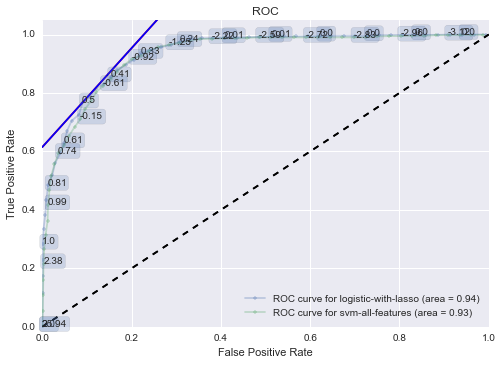

In [212]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])
slope = rat(risk_matrix)*(np.mean(ytest==0)/np.mean(ytest==1))

z1=np.arange(0.,1., 0.02)
def plot_line(ax, intercept):
    plt.figure(figsize=(12,12))
    ax=plt.gca()
    ax.set_xlim([0.0,1.0])
    ax.set_ylim([0.0,1.0])
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
    make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
    ax.plot(z1 , slope*z1 + intercept, 'k-')

#from IPython.html.widgets import interact, fixed
#interact(plot_line, ax=fixed(ax), intercept=(0.0,1.0, 0.005))

make_roc("logistic-with-lasso",clflog, ytest, Xtest, labe=200, skip=50)
make_roc("svm-all-features",clfsvm, ytest, Xtest, labe=200, proba=False, skip=50)
#.82 corresponds to the intercept predicted by calling the interact function
plt.plot(z1, slope*z1+0.615,'r')
plt.plot(z1, slope*z1+0.615,'b')

In [160]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc

In [161]:
def av_profit(tpr,fpr,util,priorp,priorn):
    profit = priorp*(util[1][1]*tpr+util[1][0]*(1.-tpr))+priorn*(util[0][0]*(1.-fpr) +util[0][1]*fpr)
    return profit
# -tnc, -fpc, -fnc, -tpc

In [162]:
def make_profit(name, clf, ytest, xtest, util, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_profit(tpr[i], fpr[i], util, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='utlity curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

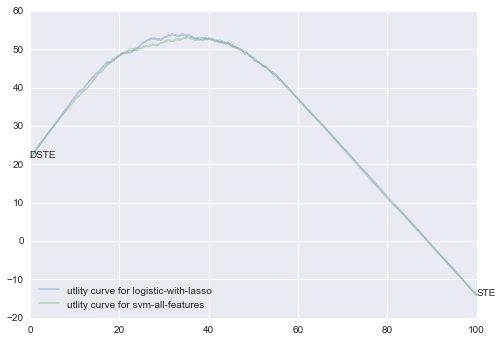

In [205]:
ax=make_profit("logistic-with-lasso", clflog, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=True)
make_profit("svm-all-features",clfsvm, ytest, Xtest, u, ax=None, threshold=False, labe=200, proba=False)
ax.annotate("STE",xy=(100,steval))
ax.annotate("DSTE",xy=(0,dsteval))
plt.legend(loc=3)

In [164]:
#Part 4
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

In [165]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
i_BidCount,12.731265,-12.731265
i_ListingType,7.226806,-7.226806
i_buyItNowAvailable,6.743514,6.743514
i_paymentMethod,2.209673,2.209673
i_nPaymentMethods,2.097285,2.097285
i_PositiveFeedbackPercent,2.066011,2.066011
i_nPhotos,1.968713,1.968713
i_topRatedListing,1.240788,-1.240788
i_PosFeedback365Day,1.218902,-1.218902


In [166]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=dftouse[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['sellingStatus'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
i_BidCount,0.597094,-0.597094
BidCount,0.348843,-0.348843
i_ListingType,0.334225,0.334225
i_buyItNowAvailable,0.308093,0.308093
i_oneDayShippingAvailable,0.302894,0.302894
i_SellerBusinessType,0.268001,-0.268001
i_AutoPay,0.263881,0.263881
i_RatingsPresent,0.256376,0.256376
i_NegFeedback365Day,0.242314,0.242314


In [167]:
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

In [168]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

In [169]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [170]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 1.0} 0.801110083256 [mean: 0.69904, std: 0.06476, params: {'svm__C': 1e-05}, mean: 0.72109, std: 0.04321, params: {'svm__C': 0.001}, mean: 0.77582, std: 0.04281, params: {'svm__C': 0.01}, mean: 0.79972, std: 0.04399, params: {'svm__C': 0.1}, mean: 0.80111, std: 0.04339, params: {'svm__C': 1.0}, mean: 0.80034, std: 0.04371, params: {'svm__C': 10.0}, mean: 0.75362, std: 0.09775, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.84
Accuracy on test data:     0.84
[[1715  157]
 [ 301  608]]
########################################################


In [171]:
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['i_paymentMethod', 'i_AutoPay', 'BidCount', 'i_GlobalShipping',
       'HandlingTime', 'i_ListingType', 'Quantity', 'i_QuantityThreshold',
       'FeedbackScore', 'i_SellerBusinessType', 'nPaymentMethods',
       'nShippingCountries', 'i_buyItNowAvailable', 'i_shippingType',
       'i_oneDayShippingAvailable', 'i_RatingsPresent',
       'NegFeedback365Day', 'PosFeedback30Day', 'PosFeedback365Day',
       'auctionLength', 'i_HandlingTime', 'i_BidCount',
       'i_NegFeedback30Day', 'i_NegFeedback365Day', 'i_PosFeedback30Day'], 
      dtype='|S27')

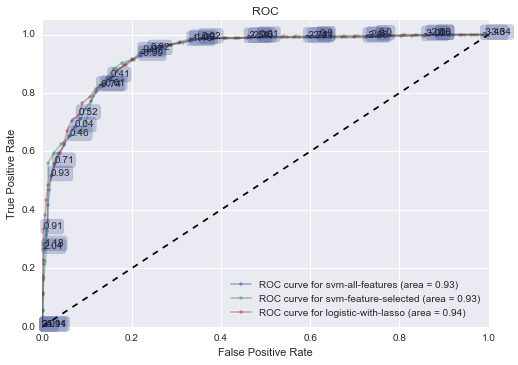

In [172]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);

In [173]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg


2194 4292


In [174]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)

In [175]:
alli=np.concatenate((jtrain[ytrain==1], ineg))
alli.shape

(4388,)

In [176]:
Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((4388, 44), (4388,))

In [177]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

In [178]:
clfsvm_b, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_new)

using reuse split
BEST {'C': 0.01} 0.818824065634 [mean: 0.77279, std: 0.05216, params: {'C': 0.001}, mean: 0.81882, std: 0.01338, params: {'C': 0.01}, mean: 0.81655, std: 0.03493, params: {'C': 0.1}, mean: 0.79239, std: 0.07483, params: {'C': 1.0}, mean: 0.79763, std: 0.06501, params: {'C': 10.0}, mean: 0.79923, std: 0.02010, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.82
Accuracy on test data:     0.76
[[1245  627]
 [  29  880]]
########################################################


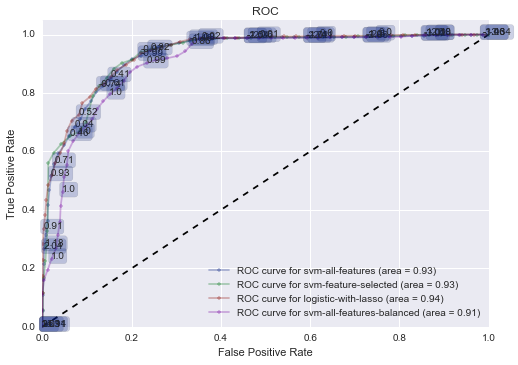

In [179]:
with sns.color_palette("dark"):
    ax=make_roc("svm-all-features",clfsvm, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("svm-feature-selected",pipelinearsvm, ytest, Xtest, ax, labe=250, proba=False, skip=50);
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

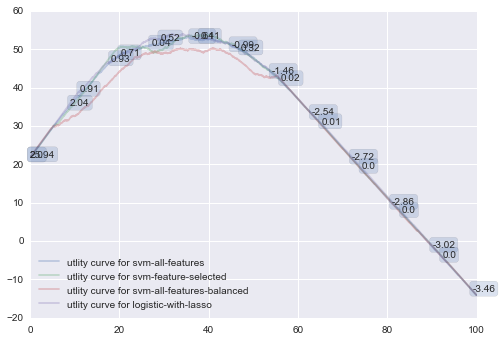

In [201]:
ax = make_profit("svm-all-features",clfsvm, ytest, Xtest, u, None, labe=250, threshold=True, proba=False)
make_profit("svm-feature-selected",pipelinearsvm, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=250, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=250, threshold=True);
plt.legend(loc=3)

In [181]:
from sklearn.svm import SVC

In [182]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [183]:
jtrain_new=np.arange(0, ytrain_new.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain_new==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain_new==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain_new[subsampled_i]
ytrain_new2=ytrain_new[subsampled_i]

In [184]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [185]:
%%time
#your code here
params = {"svm2__C": [1e8], "svm2__gamma":[1e-9,1e-7,1e-5],"svm2__kernel":["rbf"]}
clfsvm_subsampled, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm2, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'} 0.851666666667 [mean: 0.59833, std: 0.02494, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.85167, std: 0.04028, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.84833, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.79
[[1394  478]
 [  96  813]]
########################################################
CPU times: user 1.69 s, sys: 13.1 ms, total: 1.7 s
Wall time: 1.71 s


In [186]:
%%time
#your code here
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm2', SVC(C=1e8,gamma=1e-9,kernel="rbf"))])
clfsvm_k, Xtrain, ytrain, Xtest, ytest = do_classify(pipesvm3, params, dftouse,lcols, 'sellingStatus',1,reuse_split = reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'} 0.851666666667 [mean: 0.59833, std: 0.02494, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09, 'svm2__kernel': 'rbf'}, mean: 0.85167, std: 0.04028, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07, 'svm2__kernel': 'rbf'}, mean: 0.84833, std: 0.03472, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05, 'svm2__kernel': 'rbf'}]
############# based on standard predict ################
Accuracy on training data: 0.86
Accuracy on test data:     0.79
[[1394  478]
 [  96  813]]
########################################################
CPU times: user 1.64 s, sys: 5.66 ms, total: 1.64 s
Wall time: 1.65 s


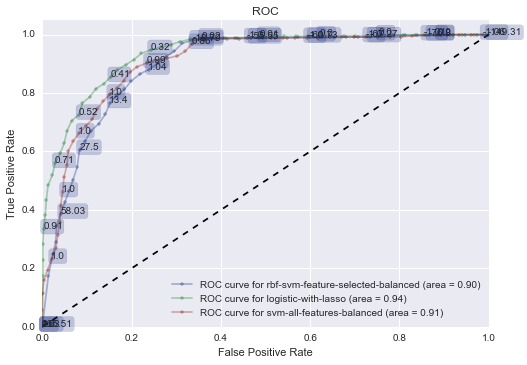

In [187]:
#Part 5
with sns.color_palette("dark"):
    ax=make_roc("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, None, labe=250, proba=False, skip=50)
    make_roc("logistic-with-lasso",clflog, ytest, Xtest, ax, labe=250, proba=True,  skip=50);
    make_roc("svm-all-features-balanced",clfsvm_b, ytest, Xtest, ax, labe=250, proba=False,  skip=50);

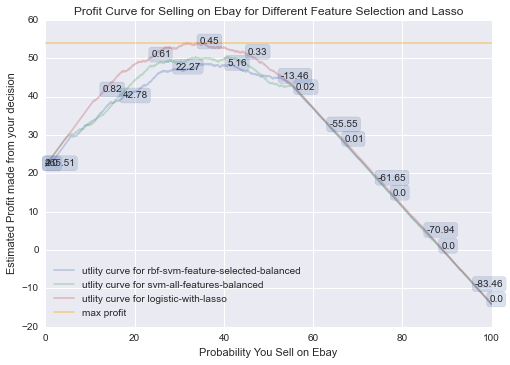

In [200]:
ax = make_profit("rbf-svm-feature-selected-balanced",clfsvm_k, ytest, Xtest, u, None, labe=300, threshold=True, proba=False)

make_profit("svm-all-features-balanced",clfsvm_b, ytest, Xtest, u, ax, labe=300, proba=False);
make_profit("logistic-with-lasso",clflog, ytest, Xtest, u, ax, labe=300, threshold=True);
plt.axhline(54, color='orange', alpha=.4, label='max profit')
plt.xlabel("Probability You Sell on Ebay")
plt.ylabel("Estimated Profit made from your decision")
plt.title("Profit Curve for Selling on Ebay for Different Feature Selection and Lasso")
plt.legend(loc=3)

## What this tells us

The x-axis on this plot tells us a probability of whether or not you sell on eBay. Our